In [1]:
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [2]:
plt.rcParams.update({"font.size": 15})


In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=0, F1=1 / 2, F=1
    )
]

polarizations = [[couplings.polarization_Z, couplings.polarization_X]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=0,
            F=1,
            F1=1 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=+1,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=1,
            F=1,
            F1=1 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        )
    ],
)


In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0=(
        "Ωl0 * phase_modulation(t, β, ωphase)*gaussian_2d(vz*t, 0.0, 1.0, laser_center,"
        " 0.0, σz, σy)"
    ),
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    P="sin(ωp*t + ϕp)",
    PZ0="P>=0",
    PX0="P<0",
    ωp=2 * np.pi * 1.6e6,
    ϕp=0.0,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
    σz=1.5e-3,
    σy=1.5e-3,
    laser_center=5e-3,
)


In [5]:
%%time
obe_system = lindblad.setup_OBE_system_transitions(
    trans, transition_selectors, 
    verbose=True,
    qn_compact= True,
    decay_channels = None
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 10.6 s
Wall time: 23.5 s


In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")


,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 0>",0.666454
"|X, J = 2>",0.333546


In [8]:
ρ_prerc = np.zeros(obe_system.H_symbolic.shape, dtype=complex)
ρ_postrc = np.zeros(obe_system.H_symbolic.shape, dtype=complex)

post_rc = np.array([0.20283862, 0.07378569, 0.07788355, 0.07378569])
for idp, pop in enumerate(post_rc):
    ρ_postrc[idp, idp] = pop

pre_rc = np.array([0.05334403, 0.05334403, 0.05334403, 0.05334403])
for idp, pop in enumerate(pre_rc):
    ρ_prerc[idp, idp] = pop


# Apparent gain
## Photons from thermal population

In [9]:
power = 40e-3
rabi = utils.rabi.power_to_rabi_gaussian_beam(
    power,
    obe_system.couplings[0].main_coupling,
    odepars.σz,
    odepars.σy,
    D=2.6675506e-30,
).real


In [10]:
odepars.Ωl0 = rabi
odepars.β = 3.8

problem = lindblad_julia.OBEProblem(odepars, ρ_prerc, tspan=(0, 50e-6))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)


In [11]:
results = lindblad_julia.do_simulation_single(problem, config=config)


In [12]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)


0.64 photons


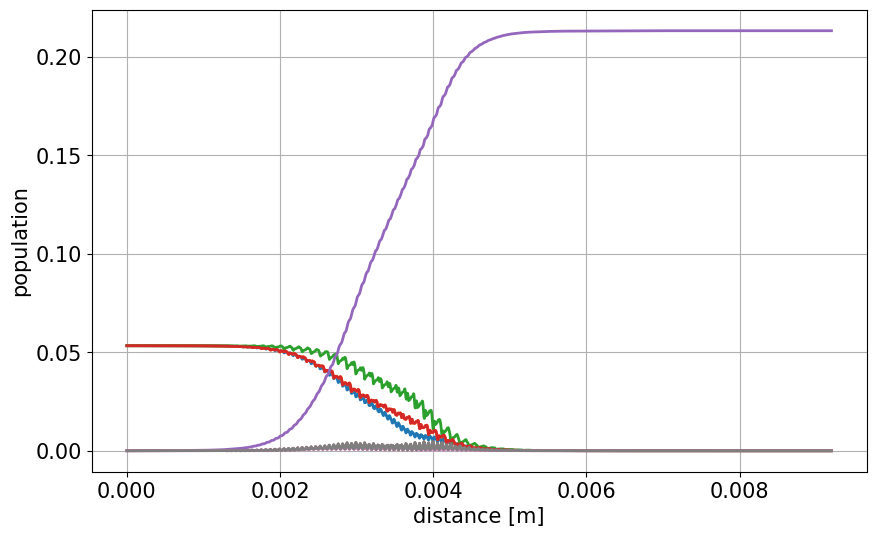

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
# ax.legend(fontsize = 14)
ax.grid(True)

nphotons_prerc = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons_prerc:.2f} photons")


## Photons from post-rc population

In [14]:
odepars.Ωl0 = rabi
odepars.β = 3.8

problem = lindblad_julia.OBEProblem(odepars, ρ_postrc, tspan=(0, 50e-6))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)


In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)


In [16]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)


1.28 photons


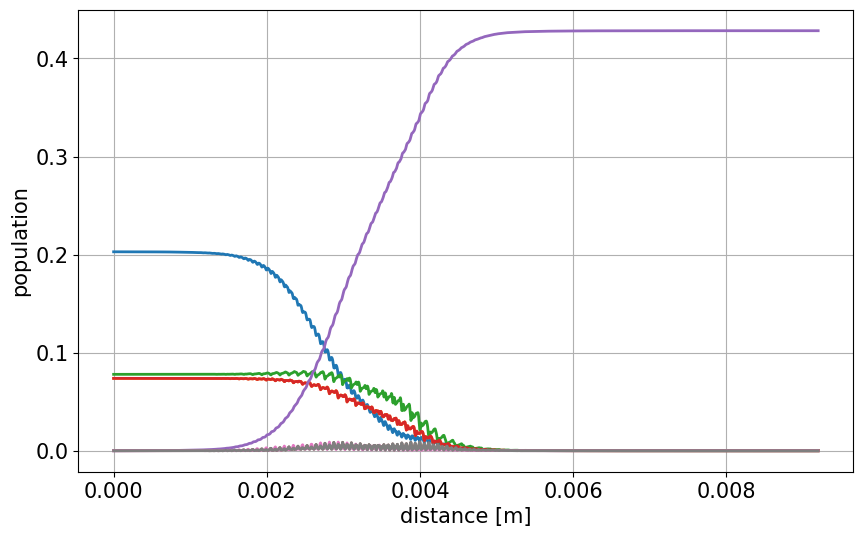

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
# ax.legend(fontsize = 14)
ax.grid(True)

nphotons_postrc = (
    np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
)
print(f"{nphotons_postrc:.2f} photons")


## Resulting gain

In [18]:
apparent_gain = nphotons_postrc / nphotons_prerc
real_gain = post_rc.sum() / pre_rc.sum()
print(f"apparent gain = {apparent_gain:.2f}")
print(f"real gain = {real_gain:.2f}")


apparent gain = 2.01
real gain = 2.01


# Scan Detuning

In [19]:
photons = []
velocities = np.linspace(-5, 5, 51)
for vx in tqdm.tqdm(velocities):
    odepars.vx = vx

    problem = lindblad_julia.OBEProblem(odepars, ρ_prerc, tspan=(0, 50e-6))
    config = lindblad_julia.OBEProblemConfig(saveat=1e-6, save_everystep=True)

    results = lindblad_julia.do_simulation_single(problem, config=config)
    photon = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
    photons.append(photon)


100%|██████████| 51/51 [00:15<00:00,  3.28it/s]


INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \perp from STIXGeneral


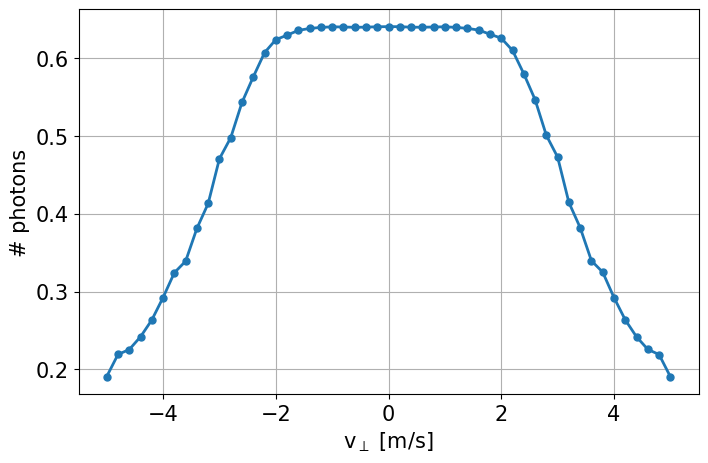

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(velocities, photons, ".-", lw=2, ms=10)

ax.set_xlabel("v$_\perp$ [m/s]")
ax.set_ylabel("# photons")

ax.grid(True)


# Scan detuning and β

In [21]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices


In [22]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")


In [23]:
vx = np.linspace(-5, 5, 101)
β = np.linspace(0, 5, 101)


## Photons from thermal population

In [24]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    abstol=1e-10,
    reltol=1e-7,
)

problem = lindblad_julia.OBEProblem(odepars, ρ_prerc, tspan=(0, 50e-6))

scan_values = [vx, β]
parameters = ["vx", "β"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ensemble_problem)


In [25]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [26]:
results_prerc = lindblad_julia.get_results_parameter_scan(ensemble_problem)


## Photons from post-rc population

In [27]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_idxs=save_idxs,
    saveat=1e-6,
    abstol=1e-10,
    reltol=1e-7,
)

problem = lindblad_julia.OBEProblem(odepars, ρ_postrc, tspan=(0, 50e-6))

scan_values = [vx, β]
parameters = ["vx", "β"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ensemble_problem)


In [28]:
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [29]:
results_postrc = lindblad_julia.get_results_parameter_scan(ensemble_problem)


## Results

INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol ⟂ from STIXGeneral


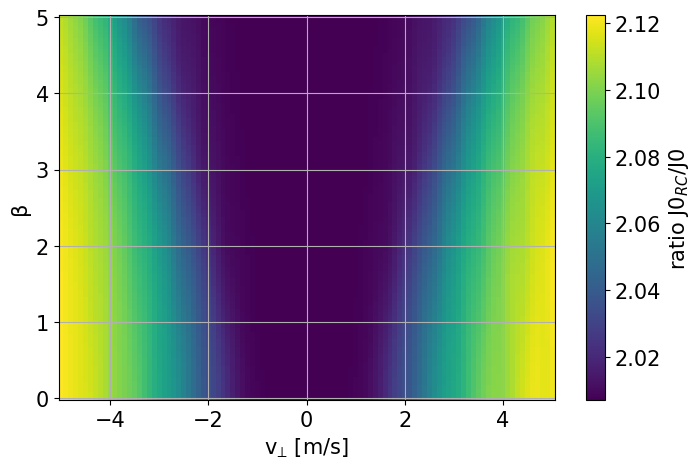

In [30]:
(x, y), z_prerc = results_prerc.scan_values, results_prerc.results
z_postrc = results_postrc.results

fig, ax = plt.subplots(figsize=(8, 5))

c = ax.pcolormesh(x, y, z_postrc / z_prerc)
cbar = fig.colorbar(c)

ax.set_xlabel("v$_⟂$ [m/s]")
ax.set_ylabel("β")
cbar.ax.set_ylabel("ratio J0$_{RC}$/J0")
ax.grid(True)
